# CS224S Assignment 4 SpeechBrain ASR

This notebook is worth 60 / 100 possible points for homework 4. You should be able to train all models in Colab. We encourage you to read the speechbrain [tutorial](https://colab.research.google.com/drive/1aFgzrUv3udM_gNJNUoLaHIm78QHtxdIz?usp=sharing#scrollTo=J6N0Fb51pFnZ) on ASR systems for further context.

**Goals**
In this part of the homework, you will:
1. Run an existing SpeechBrain ASR model on a new dataset (HarperValleyBank)
2. Evaluate word error rate (WER) and perform comparative error analysis to help adapt an existing model to new data and understand error patterns.
3. Fine tune an end-to-end neural ASR system on a domain-specific dataset to improve performance. 

**Note:** You will need to make a copy of this Colab notebook in your Google Drive before you can edit it. Please make sure to change your Runtime to GPU.

# Dependencies 

If you have any issues using `gdown` the same data and config files are available directly via Google Drive [here](https://drive.google.com/drive/folders/1yKSJ6fSSs24c2JL8kpqa311YTELWZ2p7)

In [ ]:
# setup
!gdown 1k2XrxbCz76MG1LptUpcFgocelLMGk5Mu
!unzip -q hvb.zip
!mv content/data /content/
!rm -r /content/content

!gdown 1v_3Kl8OrUd6_1_D0ZGoYVFEuOKhZ7YMo # train.py
!gdown 17cQIpx5kLLMCD23EDaE0EYg2E9LPqMCF # train.yaml
!gdown 1CWYOD2PC97gXguW4krc9122HKAraHkYS # inference.yaml

!pip install speechbrain -q

In [1]:
!pip install speechbrain


C:\Users\Phuc\Desktop\CS224S-slp\HW4>doskey make=mingw32-make.exe 
   ---------------------------------------- 0.0/630.6 kB ? eta -:--:--
   --- ------------------------------------ 61.4/630.6 kB 1.7 MB/s eta 0:00:01
   ------- -------------------------------- 122.9/630.6 kB 1.4 MB/s eta 0:00:01
   --------------- ------------------------ 245.8/630.6 kB 1.9 MB/s eta 0:00:01
   --------------------------------- ------ 532.5/630.6 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 630.6/630.6 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/116.4 kB ? eta -:--:--
   ---------------------------------------- 116.4/116.4 kB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/117.8 kB ? eta -:--:--
   ---------------------------------------- 117.8/117.8 kB 3.5 MB/s eta 0:00:00


In [3]:
import speechbrain as sb
from speechbrain.pretrained import EncoderDecoderASR
import json
import torchaudio
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
from torch import nn
from tqdm import tqdm
from collections import Counter
from IPython.display import Audio
from scipy.io import wavfile

device = 'cuda' if torch.cuda.is_available() else 'cpu'

C:\Users\Phuc\anaconda3\envs\python3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
C:\Users\Phuc\anaconda3\envs\python3.10\lib\site-packages\speechbrain\utils\torch_audio_backend.py:22: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
C:\Users\Phuc\anaconda3\envs\python3.10\lib\site-packages\speechbrain\utils\torch_audio_backend.py:22: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remov

# Part 1: Evaluate a pretrained CRDNN model

We continue to use the Harper Valley Bank dataset as in HW3. This time, we aim to build and evaluate our own ASR system with the SpeechBrain framework.

Here, we load a CRDNN model pretrained on LibriSpeech. SpeechBrain has some utils with built-in options to source pre-trained models from a repository on HuggingFace. In this homework we will load a model from HuggingFace, use it for inference, and then fine tune the model on our dataset. 

For now, we'll run the model for inference on our dataset.

In [3]:
crdnn = EncoderDecoderASR.from_hparams(
    source='speechbrain/asr-crdnn-rnnlm-librispeech',
    savedir='asr-crdnn-rnnlm-librispeech',
    run_opts={'device': 'cuda'}
)

hyperparams.yaml: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.49k/4.49k [00:00<?, ?B/s]
normalizer.ckpt: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.41k/1.41k [00:00<00:00, 1.40MB/s]
asr.ckpt: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480M/480M [02:52<00:00, 2.78MB/s]
lm.ckpt: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212M/212M [01:26<00:00, 2.46MB/s]
tokenizer.ckpt: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

The manifests we prepared for using with SpeechBrain are jsons with the structure
```
{
    "15748": {
        "wav": "/content/data/segments/15748.wav",
        "length": 1.86,
        "words": "WHAT DAY WOULD YOU LIKE FOR YOUR APPOINTMENT"
    },
    ...
}
```

We first load them and define a function to batch them into a format that our `EncoderDecoderASR` object can ingest

In [11]:
TEST_SIZE = 200 # for faster processing

with open('content/data/test_manifest.json', 'r') as f:
    test_manifest = json.load(f)
test_manifest = {
    k: v for k, v in list(test_manifest.items())[:TEST_SIZE]
}

def batchify(manifest, batch_size):
    keys = list(manifest.keys())
    wav_paths = list(map(lambda x: x['wav'], manifest.values()))
    iterable = zip(keys, wav_paths)
    num_examples = len(manifest)
    for i in range(0, num_examples, batch_size):
        batch_wavs = nn.utils.rnn.pad_sequence([
            torchaudio.load(path)[0].squeeze(0)
            for path in wav_paths[i:min(i + batch_size, num_examples)]
        ], batch_first=True)
        batch_keys = keys[i:min(i + batch_size, num_examples)]
        batch_wav_lens = torch.tensor([
            manifest[key]['length'] for key in batch_keys
        ])
        batch_wav_lens = batch_wav_lens / batch_wav_lens.max()
        yield batch_keys, batch_wavs, batch_wav_lens

Next, we feed our test examples through the ASR model:

In [16]:
true_dict = {key: test_manifest[key]['words'] for key in test_manifest}

def inference(model, test_manifest, batch_size=8):
    torch.cuda.empty_cache()
    pred_dict = {}
    for keys, wavs, wav_lens in tqdm(batchify(test_manifest, batch_size), total=round(len(test_manifest) / batch_size + 0.5)):
        transcriptions, _ = model.transcribe_batch(wavs.to(device), wav_lens.to(device))
        for key, transcription in zip(keys, transcriptions):
            pred_dict[key] = transcription
    return pred_dict

# pred_dict = inference(crdnn, test_manifest)

## **Task: Evaluate WER of pre-trained model inferences on the new dataset (5 points)**

Finally, we check the word error rate on our test set. Note that we want WORD error rate, so we need to split our transcripts into lists of words. 

You don't need to implement anything new here. Just follow along and ensure you can run the code to obtain WER on the results you just generated. 

In [9]:
# this data structure stores WER information we use later. 
details_by_utterance = sb.utils.edit_distance.wer_details_by_utterance(
    {k: v.split() for k, v in true_dict.items()},
    {k: v.split() for k, v in pred_dict.items()},
)

In [10]:
# word error rate (WER) summary using data structure we just created
sb.utils.edit_distance.wer_summary(details_by_utterance)

{'WER': 71.5564738292011,
 'SER': 87.0,
 'num_edits': 1039,
 'num_scored_tokens': 1452,
 'num_erraneous_sents': 174,
 'num_scored_sents': 200,
 'num_absent_sents': 0,
 'num_ref_sents': 200,
 'insertions': 402,
 'deletions': 113,
 'substitutions': 524}

We expect WER of the off the shelf system to be somewhat high on HVB data (around 74%+ WER). That is quite high! Note that we already re-sampled the audio to 16kHz to make the HVB audio features more similar to the training inputs of the pre-trained model. 

Often times ASR errors have specific error modes or correlations -- let's see if we can understand where our pre-trained system is failing on HVB data. We can start to investigate where our system is making mistakes by checking some of the top missed utterances.

In [11]:
def summarize(detail_dict, true_dict, pred_dict):
    print(f"{detail_dict['key']}: {detail_dict['WER']}")
    print(f"\tTrue: {true_dict[detail_dict['key']]}")
    print(f"\tPred: {pred_dict[detail_dict['key']]}")

for wer_dict in sb.utils.edit_distance.top_wer_utts(details_by_utterance, 10)[0]:
    summarize(wer_dict, true_dict, pred_dict)

1130: 2400.0
	True: ALRIGHT
	Pred: RIPE RIGHT RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE RIPE
3020: 737.5
	True: OKAY THANKS AND WHAT IS THE BILL AMOUNT
	Pred: OKAY THANKS AND WHAT IF YE DON'T AMOUNT THANKS AN WHAT IF YE BUILD A MOUNT THINK AN WHAT IF YE DON'T AMOUNT THINK AN WHAT IF YE DON'T AMOUNT THINK AN WHAT IF YE DON'T AMOUNT THINK AN WHAT IF YE DON'T AMOUNT THINK AN WHAT IF YE DON'T AMOUNT THANKS AN WHAT IF YE DON'T AMOUNT THANKS AN WHAT IF YE BILL AMOUNT
22147: 620.0
	True: WHAT IS THE TRANSFER AMOUNT
	Pred: OF THE TRANSFER AMOUNT AMOUNT AMOUNT AMOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT MOUNT
20613: 600.0
	True: BYE
	Pred: I DON'T EAT DRINK EAT DRINK
5390: 600.0
	True: NO
	Pred: NOW'S NOW NOW NOW NOW NOW
7385: 558.3333333333334
	True: NO I GOT ALL I NEED FOR TODAY THANK YOU SO MUCH
	Pred: NO I DON'T KNOW 

Seems that our predictions keep outputting the same word over and over. Let's see why

## **Task: Plot spectrograms and listen to mis-transcribed examples (10 points)** 

Select some examples the model mis-transcribes, and try to build a hypothesis around what in the data is associated with the model making mistkes. 
Visualize at least 3 example mistake types:
- Repeated wrong word
- A few correct words but clearly wrong transcript
- Another example with transcription error of your choice

For each example:
- Play the audio
- Print the true and predicted transcripts
- Plot a log spectrogram
- Comment (in text) on why you think the model may have made a mistake on this audio. It could include issues like channel quality, background noise, long sections of silence / endpointing issues, etc. 

In [17]:
Audio(test_manifest['3020']['wav'])

Another example code snippet to help you start. See HW1 for log spectrogram plotting if you need help.

In [18]:
example = details_by_utterance[0]
summarize(example, true_dict, pred_dict)
Audio(test_manifest[example['key']]['wav'])

15748: 37.5
	True: WHAT DAY WOULD YOU LIKE FOR YOUR APPOINTMENT
	Pred: WHAT DAY WOULD YOU LIKELY APPOINT APPOINTMENT


In [19]:
def plot_spectrogram(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Create a log spectrogram
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

def summarize(example, true_dict, pred_dict):
    key = example['key']
    true_transcript = true_dict[key]
    pred_transcript = pred_dict[key]
    
    print("True Transcript:", true_transcript)
    print("Predicted Transcript:", pred_transcript)

# Example: Repeated wrong word
# example1 = details_by_utterance[0]
# summarize(example1, true_dict, pred_dict)
# plot_spectrogram(test_manifest[example1['key']]['wav'])
# Audio(test_manifest[example1['key']]['wav'])

True Transcript: UH CHECKING UH FROM MY CHECKING ACCOUNT
Predicted Transcript: I'D HIDDEN AH FROM A KICKING A COW


C:\Users\Phuc\AppData\Local\Temp\ipykernel_26420\751981479.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


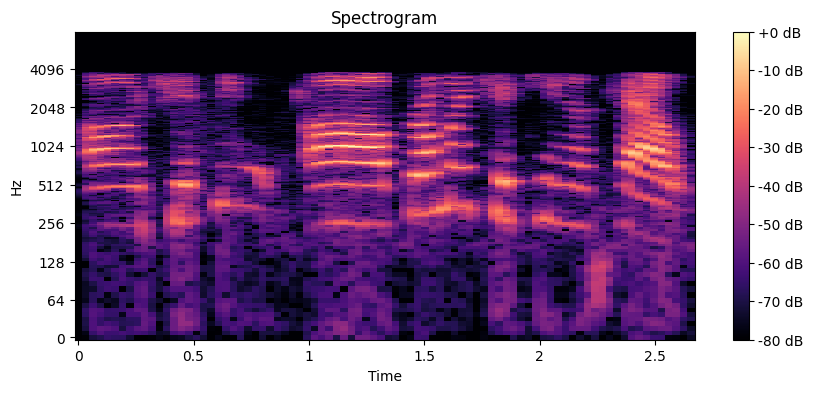

In [23]:
# Example: A few correct words but clearly wrong transcript
example2 = details_by_utterance[1]
summarize(example2, true_dict, pred_dict)
plot_spectrogram(test_manifest[example2['key']]['wav'])
Audio(test_manifest[example2['key']]['wav'])

True Transcript: <UNK>
Predicted Transcript: AIN'T YE


C:\Users\Phuc\AppData\Local\Temp\ipykernel_26420\751981479.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


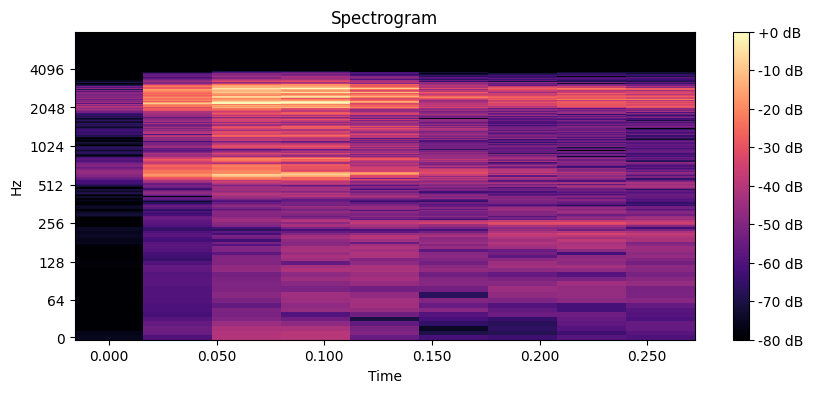

In [24]:
# example with transcription error
example3 = details_by_utterance[2]
summarize(example3, true_dict, pred_dict)
plot_spectrogram(test_manifest[example3['key']]['wav'])
Audio(test_manifest[example3['key']]['wav'])

(Hint: In our initial checks, poor audio quality seems to be associated with repeated word errors.)

## **Task: Filtering out bad data (10 points)**

We've just identified that utterances with many repeated word predictions might be associated with audio and endpointing quality in the HVB dataset. To avoid seeing only this error mode when looking at test results, let's try filtering out from our dev set utterances with repeated word predictions.

Your task is to define a simple heuristic that ignores utterances from dev set computation. You may achieve this by creating a filtered dev set, and then re-running analysis on it. 

Report WER overall and top WER utterances on your reduced dev set. This should have errors where the predictor is closer to the true transcript than before. 

Below is some helper code to filter out (e.g. repeated words in predictions)

In [27]:
def repeated_words(transcript):
    """
    Function that returns True or False if `transcript` suffers from the
    repeated words error or not.
    """
    #############################
    #### YOUR CODE GOES HERE ####
    words = transcript.split()
    return len(set(words)) < len(words)
    #############################

And let's filter our predictions based on this and check what proportion of examples this kind of error affects

In [29]:
pred_dict_filtered = {
    k: v for k, v in pred_dict.items() if not repeated_words(v)
}
true_dict_filtered = {k: true_dict[k] for k in pred_dict_filtered}

print(1 - len(pred_dict_filtered) / len(pred_dict))
# Calculate the proportion of examples affected by the repeated words error
proportion_filtered = 1 - len(pred_dict_filtered) / len(pred_dict)
print(f"Proportion of examples affected by repeated words error: {proportion_filtered:.2%}")

0.25
Proportion of examples affected by repeated words error: 25.00%


And we finally print our WER stats again on this filtered set

In [30]:
details_by_utterance_filtered = sb.utils.edit_distance.wer_details_by_utterance(
    {k: v.split() for k, v in true_dict_filtered.items()},
    {k: v.split() for k, v in pred_dict_filtered.items()},
)
sb.utils.edit_distance.wer_summary(details_by_utterance_filtered)

{'WER': 45.436105476673426,
 'SER': 82.66666666666667,
 'num_edits': 448,
 'num_scored_tokens': 986,
 'num_erraneous_sents': 124,
 'num_scored_sents': 150,
 'num_absent_sents': 0,
 'num_ref_sents': 150,
 'insertions': 40,
 'deletions': 88,
 'substitutions': 320}

More reasonable, but still not great! Remember to finish displaying top WER utterances on your reduced set as requested for this task. 

In [35]:
#############################
#### YOUR CODE GOES HERE ####

# Report top WER utterances on the reduced set
top_wer_utterances_filtered = sorted(details_by_utterance_filtered, key=lambda x: x['WER'], reverse=True)[:5]

print("\nTop WER Utterances on Filtered Dev Set:")
for entry in top_wer_utterances_filtered:
    key = entry['key']
    wer_value = entry['WER']
    true_transcript = true_dict_filtered[key]
    pred_transcript = pred_dict_filtered[key]
    
    print(f"Key: {key}, WER: {wer_value:.4f}, True Transcript: {true_transcript}, Predicted Transcript: {pred_transcript}")
#############################


Top WER Utterances on Filtered Dev Set:
Key: 17273, WER: 200.0000, True Transcript: <UNK>, Predicted Transcript: AIN'T YE
Key: 16366, WER: 200.0000, True Transcript: FOREST, Predicted Transcript: WAR RHYMMYMMYMMMMMMMMMMMMMMYMMMMMMMMMMMMMYMMMMMMMMMMYMMMMMMMMYMMMMMMMMYMMMMMMMMYMMMMMMMMYMMMMMMMMYMMMMMMMMYMMMMMMYMMMMMMYMMMMMMYMMMMMMYMMMMMMYMMMMMM
Key: 23042, WER: 200.0000, True Transcript: OREGON, Predicted Transcript: A GUN
Key: 16894, WER: 200.0000, True Transcript: YOU TOO, Predicted Transcript: YOU'RE HERE THANK YOW
Key: 5533, WER: 175.0000, True Transcript: THANK YOU FOR CALLING, Predicted Transcript: DON'T GIVE HER CALLING HAVE A GREAT DAY


# Part 2: Finetune the pretrained CRDNN model

The performance of this off the shelf model is disappointing and fundamentally, the model was trained on a different data domain than call center transcripts. To see if we can get some better performance on our dataset, we fine tune the model and test it in this part. For this experiment, you won't need to modify it much. Just get training working, and you can try adjusting some training or decoding parameters as you like. The key thing to learn here is simply how it looks to work with SpeechBrain and fine tune on a new corpus. This is a relatively state-of-the-art approach to building and adjusting ASR models you might use in industry projects (for example).

We've set up the training script, experiment yaml, and inference yaml for you, but we encourage you to take a look at how it works (and most importantly what an neat ML experiment yaml file looks like). Training this model for 2 epochs on Colab GPU should take around **1.5 hours**.

The model will save checkpoints during training which you can specify for use during inference / testing below. That means you should be able to use a fine tuned version of the model, even if you don't wait the full time for the model to completely train. It is okay to submit the homework with your fine tuning model partially trained, but not 2 full epochs. 

In [ ]:
# this downloads the training and config files for our fine tuning setup
!gdown 1v_3Kl8OrUd6_1_D0ZGoYVFEuOKhZ7YMo # train.py
!gdown 17cQIpx5kLLMCD23EDaE0EYg2E9LPqMCF # train.yaml
!gdown 1CWYOD2PC97gXguW4krc9122HKAraHkYS # inference.yaml

### Training configuraiton

There are two files you've just downloaded which specify the architecture to train, and the main training loop for improving the neural net ASR system. 

* `train.yaml` is the yaml config file SpeechBrain uses to specify both the network / ASR system architecture, as well as the parameters of training procedures, loss functions, datasets, etc. This is a good starting point for understanding the architecture of the ASR system you're working with. Note that you are not able to modify much about the ASR network architecture as it needs to match what we load from file. You can adjust things like loss functions weights, learning rate, and training time to adjust the fine tuning setup. 
* `train.py` specifies the main training loop for fitting the acoustic model. You do not need to modify this file. 

### **Task: Run fine tuning training. (15 points)**

Edit the training yaml file and run the training loop as shown below. You should see training and validation loss < 1.75 after epoch 1. 

Run training, and show your training output to validate the model learns something useful and your fine tuning training is configured properly. Ensure your training and validation loss values are displayed somewhere in the output when you submit your solution. 

In [ ]:
import torch
torch.cuda.empty_cache()

# !python train.py train.yaml --batch_size=4
# OOM on batch_size=5

%run -i train.py train.yaml --batch_size=4

C:\Users\Phuc\anaconda3\envs\python3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
C:\Users\Phuc\anaconda3\envs\python3.10\lib\site-packages\speechbrain\utils\torch_audio_backend.py:22: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
C:\Users\Phuc\anaconda3\envs\python3.10\lib\site-packages\speechbrain\utils\torch_audio_backend.py:22: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remov

./content/data\rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
speechbrain.pretrained.fetching - Fetch lm.ckpt: Delegating to Huggingface hub, source speechbrain/asr-crdnn-rnnlm-librispeech.
speechbrain.pretrained.fetching - HF fetch: C:\Users\Phuc\.cache\huggingface\hub\models--speechbrain--asr-crdnn-rnnlm-librispeech\snapshots\d9760a0bef6c6718d30ad1271f7d05980d435677\lm.ckpt
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Delegating to Huggingface hub, source speechbrain/asr-crdnn-rnnlm-librispeech.
speechbrain.pretrained.fetching - HF fetch: C:\Users\Phuc\.cache\huggingface\hub\models--speechbrain--asr-crdnn-rnnlm-librispeech\snapshots\d9760a0bef6c6718d30ad1271f7d05980d435677\tokenizer.ckpt
speechbrain.pretrained.fetching - Fetch asr.ckpt: Delegating to Huggingface hub, source speechbrain/asr-crdnn-rnnlm-librispeech.
speechbrain.pretrained.fetching - HF fetch: C:\Users\Phu

 12%|██████████████████                                                                                                                                   | 413/3405 [21:58<3:42:33,  4.46s/it, train_loss=3.68]

# Part 3: Evaluate our finetuned model


To run inference, we need to use a different yaml to be compatible with the `EncoderDecoderASR` class. 

NOTE: You need to set your checkpoint path in a few locations to make this work. Be careful your paths are set before other debugging if things aren't working (e.g. trying to download from HuggingFace)

To get inference working there are two steps:
1. Note the directory that your checkpoints are saved in (under `./results/CRDNN_BPE_960h_LM/2602/save/{your ckpt here}`)
2. Paste this directory into the ckptdir entry in `inference.yaml`
3. Paste this directory after the `ckpt_path = ` in the below cell.

We can then use the same inference procedure as Part 1.
NOTE: set the `ckpt_path` below AND change the path in `inference.yaml` before or after it is copied into your checkpoint path.


In [1]:
ckpt_path = "./results/CRDNN_BPE_960h_LM/2602/save/CKPT+2024-01-16+00-15-45+00"
!cp inference.yaml {ckpt_path}


C:\Users\Phuc\Desktop\CS224S-slp\HW4>doskey make=mingw32-make.exe 


'cp' is not recognized as an internal or external command,
operable program or batch file.


## **Task: Run inference on your reduced test set** (5 points)

Now we're ready to evaluate our model on our previous test set. Generate predictions by setting up a model object, and calling `inference()`. Remember your checkpoint paths must be set correctly in the copy of inference.yaml read to run inference. For this step simply populate pred_dict with inferences from your reduced dev/test set from before. You will use this for WER analysis in the next step.

NOTE: Running inference on ~200 utterances might require ~45 minutes of computation on a Colab cpu. The code below uses CPU inference as we could not get checkpoint-loaded DNNs to work with SpeechBrain's inference on the GPU (you are free to try this). To earn full credit for the homework, you can run on as few as 50 test utterances, but try to choose interesting test examples if you use fewer.

In [14]:
device = 'cpu'
our_model = EncoderDecoderASR.from_hparams(
    source=ckpt_path, 
    hparams_file='inference.yaml', 
    savedir="./",
    run_opts={'device': device}
)

In [15]:
pred_dict = inference(our_model.to(device), test_manifest)

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 25/26 [43:05<01:43, 103.42s/it]


## **Task: WER analysis on fine tuned model's predictions** (10 points)

Report WER on the dev set for the fine tuned model. Include the full WER summary information provided by the SpeechBrain util. 

In our experiments, fine tuning yields a WER < 50%, which is an improvement compared with the original system. This is without filtering the dev set for noisy examples. 

In [17]:
details_by_utterance = sb.utils.edit_distance.wer_details_by_utterance(
    {k: v.split() for k, v in true_dict.items()},
    {k: v.split() for k, v in pred_dict.items()},
)
sb.utils.edit_distance.wer_summary(details_by_utterance)

{'WER': 36.15702479338843,
 'SER': 57.5,
 'num_edits': 525,
 'num_scored_tokens': 1452,
 'num_erraneous_sents': 115,
 'num_scored_sents': 200,
 'num_absent_sents': 0,
 'num_ref_sents': 200,
 'insertions': 342,
 'deletions': 58,
 'substitutions': 125}

In [18]:
# As before, print the predicted and true utterances for some large mistakes
#############################
#### YOUR CODE GOES HERE ####
top_wer_utterances_sorted = sorted(details_by_utterance, key=lambda x: x['WER'], reverse=True)[:5]

print("\nTop WER Utterances on Filtered Dev Set:")
for entry in top_wer_utterances_sorted:
    key = entry['key']
    wer_value = entry['WER']
    true_transcript = true_dict[key]
    pred_transcript = pred_dict[key]
    
    print(f"Key: {key}, WER: {wer_value:.4f}, True Transcript: {true_transcript}, Predicted Transcript: {pred_transcript}")
#############################


Top WER Utterances on Filtered Dev Set:
Key: 7225, WER: 1166.6667, True Transcript: YOU TOO BYE, Predicted Transcript: SURE I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY
Key: 14202, WER: 700.0000, True Transcript: WHICH ACCOUNT WOULD YOU LIKE TO CHECK, Predicted Transcript: WHICH ACCOUNT WOULD YOU LIKE TO CHECK WOULD YOU LIKE TO CHECK MY CHECKING TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK MY CHECKING TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK TO CHECK
Key: 17150, WER: 550.0000, True Transcript: THE CITY AND STATE, Predicted Transcript: THE CITY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY I'M SORRY
Key: 17100, WER: 500.0000, True Transcript: WHICH ACCOUNT WOULD YOU LIKE TO CHECK, Predicted Transcript: WHICH ACCOUNT WOULD YOU 

## **Task: Investigate particular utterances and describe errors** (5 points)

Plot some specific utterances as spectrograms and give examples on how the fine tuned model makes mistkes. Can you hypothesize ways to improve the model based on errors you see? It's okay if actually trying the ideas isn't feasible in the homework.

True Transcript: UH CHECKING UH FROM MY CHECKING ACCOUNT
Predicted Transcript: ABSOLUTELY ABSOLUTELY CHECKING ACCOUNT


C:\Users\Phuc\AppData\Local\Temp\ipykernel_28628\3610871771.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


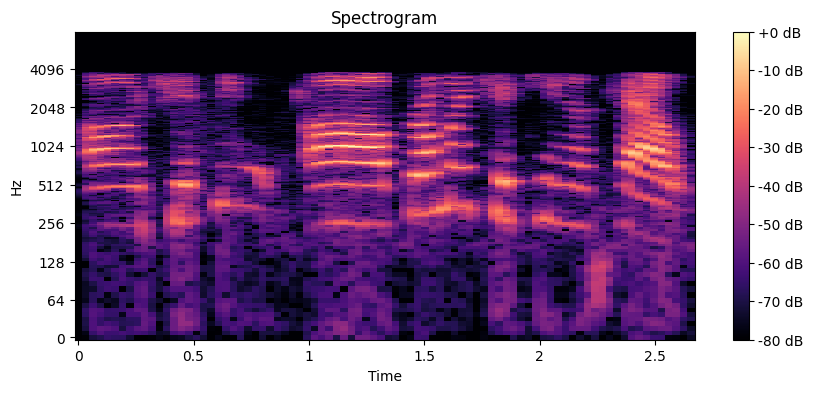

In [21]:
#############################
#### YOUR CODE GOES HERE ####
example4 = details_by_utterance[1]
summarize(example4, true_dict, pred_dict)
plot_spectrogram(test_manifest[example4['key']]['wav'])
Audio(test_manifest[example4['key']]['wav'])
#############################

# Extra Credit: Iterate to improve this model (up to 20 points)

The WER still isn't great, and 173M parameters for this domain-specific ASR system is quite a lot. Can you tweak the training script and yamls to perhaps try other models with or without pretraining, change the architecture, or change the training hyperparameters to improve the WER further? 

We will award >= 10 points for any system that improves upon the WER of basic fine tuning. And we will award 20 points for the best WER system demonstrated. You may try training a speechbrain model from scratch, or changing the fine tuning and decoding of the model above. 

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################